In [1]:
# Install fluidsynth
!apt install fluidsynth -qq
!pip install --upgrade pip -qq
!pip install --upgrade Pillow pretty_midi pyfluidsynth pypianoroll -qq

fluidsynth is already the newest version (2.1.1-2).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.3 MB/s eta 0:00:00


In [2]:
# Mount drive and cd to notebook folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd "/content/drive/MyDrive/pato/upf-smc/Patricio SMC Thesis 2023"

import sys
COLAB_WORKDIR = "/content/drive/MyDrive/pato/upf-smc/Patricio SMC Thesis 2023"
if COLAB_WORKDIR not in sys.path:
  sys.path.append(COLAB_WORKDIR)
print(sys.path)

Mounted at /content/drive
/content/drive/MyDrive/pato/upf-smc/Patricio SMC Thesis 2023
['/content', '/env/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/pato/upf-smc/Patricio SMC Thesis 2023']


In [3]:
# Import requirements
import glob
import wave
from base64 import b64encode
from io import BytesIO
from IPython.display import Audio, HTML, display
from PIL import Image

import numpy as np
import pretty_midi as pm
import pypianoroll

In [4]:
SAMPLE_RATE = 44100

def mk_wav(arr):
    """Transform a numpy array to a PCM bytestring

    Adapted from https://github.com/ipython/ipython/blob/main/IPython/lib/display.py#L146
    """
    scaled = arr * 32767
    scaled = scaled.astype("<h").tobytes()

    fp = BytesIO()
    waveobj = wave.open(fp,mode='wb')
    waveobj.setnchannels(1)
    waveobj.setframerate(SAMPLE_RATE)
    waveobj.setsampwidth(2)
    waveobj.setcomptype('NONE','NONE')
    waveobj.writeframes(scaled)
    val = fp.getvalue()
    waveobj.close()

    return val

def mk_audio_el(midi):
    audio = midi.fluidsynth(fs=SAMPLE_RATE)
    wav = mk_wav(audio)
    b64 = b64encode(wav).decode('ascii')
    return f'<audio controls="controls"><source src="data:audio/wav;base64,{b64}" type="audio/wav"/></audio>'

def mk_img_el(img):
  image_io = BytesIO()
  img.save(image_io, "PNG")
  return f"<img src=data:image/png;base64,{b64encode(image_io.getvalue()).decode('ascii')} />"

In [5]:
drum_map_9_voice = {
    36: 36,
    38: 38,
    40: 38,
    37: 38,
    48: 50,
    50: 50,
    45: 47,
    47: 47,
    43: 43,
    58: 43,
    46: 46,
    26: 46,
    42: 42,
    22: 42,
    44: 42,
    49: 49,
    55: 49,
    57: 49,
    52: 49,
    51: 51,
    59: 51,
    53: 51,
}

In [6]:
# Specify parameters

filepath = "input/slakh00006_S00/segrolls_512x512_2bar_24res/bar40_42_subdivision3792-3984.png"
# filepath = "input/rtb-boska/img_24res/3_512x512.png"

# TODO: parse n_bars and beat_resolution from filename
n_bars = 2
beat_resolution = 24

(192, 128) upscaled 5x to (960, 640)




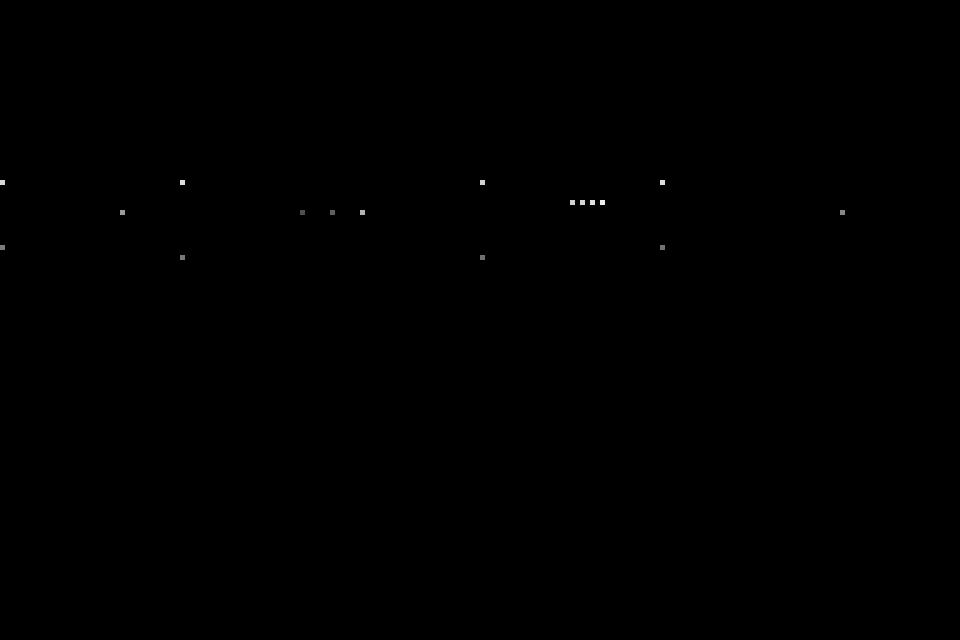

In [7]:
# Load the image
im = Image.open(filepath)

# Crop padding from piano roll
(left, top, right, bottom) = (0, 0, beat_resolution * 4 * n_bars, 128)
im_cropped = im.crop((left, top, right, bottom))
cropped = np.asarray(im_cropped)

# Map pixel brightness to MIDI velocity
roll = np.array(list(map(lambda x: np.interp(x, [0, 255], [0, 127]).astype(np.float32), cropped)))

# Convert the piano roll to MIDI
note_duration = .5 / beat_resolution  # a reasonable bpm close to 120 (?)
# TODO: determine if is_drum based on program num
# voices = [drum_map_9_voice[i] if i in drum_map_9_voice else i for i in range(128)]
# instruments = [
#     pm.Instrument(program=v, is_drum=True, name=pm.note_number_to_drum_name(v))
#     for v in voices
# ]
instrument = pm.Instrument(program=1, is_drum=True)
for voice in range(len(roll)):
    events = roll[voice]
    for event_ix, vel in enumerate(events):
        start = event_ix * note_duration
        note = pm.Note(
            velocity=vel, pitch=drum_map_9_voice.get(voice, voice), start=start, end=start + note_duration
        )
        instrument.notes.append(note)
        # instruments[voice].notes.append(note)

track = pm.PrettyMIDI(resolution=beat_resolution)
track.instruments.append(instrument)
# for i in instruments:
#     track.instruments.append(i)

# Create the audio playback element
audio_el = mk_audio_el(track)

# Create the image element
size = im_cropped.size
upscale_factor = 960 // size[0]
display_size = tuple(upscale_factor * x for x in size)
print(f"{size} upscaled {upscale_factor}x to {display_size}\n")
display_im = im_cropped.resize(display_size, resample=Image.Resampling.BOX)
img_el = mk_img_el(display_im)

# Display the audio and video
HTML(f"<div><p>{audio_el}</p>{img_el}</div>")

In [8]:
# From files

audio_els = {}
for fp in glob.glob('input/rtb-boska/midi/*.mid'):
    midi = pm.PrettyMIDI(fp)
    midi.instruments[0].is_drum = True
    el = mk_audio_el(midi)
    audio_els[fp] = el

html = ''.join([f"<p>{v} {k}</p>" for k,v in audio_els.items()])

HTML(html)